In [3]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook
from data_util import *

## load velocity dispersion and velocity

In [4]:
snr_per_bin = 23
file_id = './data_products/systematic_marginalized_velocity_dispersion_snr_per_bin_{}'.format(snr_per_bin)

binned_dispersion = np.loadtxt(file_id+'_mean.txt')
covariance = np.loadtxt(file_id+'_covariance.txt')


file_id = './data_products/systematic_marginalized_velocity_snr_per_bin_{}'.format(snr_per_bin)

binned_velocity = np.loadtxt(file_id+'_mean.txt')
covariance_velocity = np.loadtxt(file_id+'_covariance.txt')

In [5]:
covariance.shape

(36, 36)

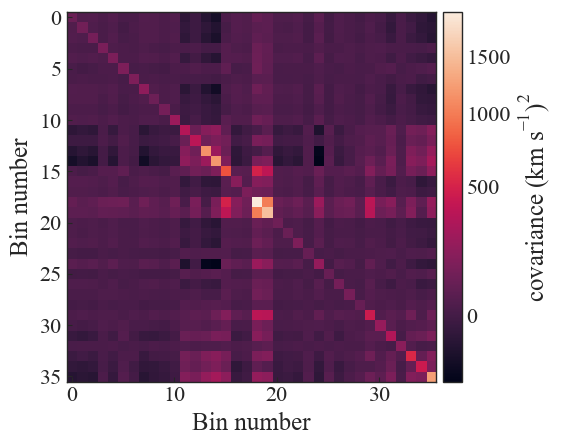

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import simple_norm
import paperfig as pf

pf.set_fontscale(2.)

norm = simple_norm(covariance, 'sqrt')

fig = plt.figure()
ax = fig.add_subplot(111)


im = ax.imshow((covariance), norm=norm) #, cmap='gist')
#plt.colorbar(cbar, label=r'(km/s)${}^2$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad='2%')
cbar = fig.colorbar(im, cax=cax, label=r'covariance (km s$^{-1}$)$^{2}$')

ax.set_xlabel('Bin number')
ax.set_ylabel('Bin number')

fig.tight_layout()

# fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/velocity_dispersion_covariance.pdf', 
#             bbox_inches='tight'
#            )

### loading bin mapping

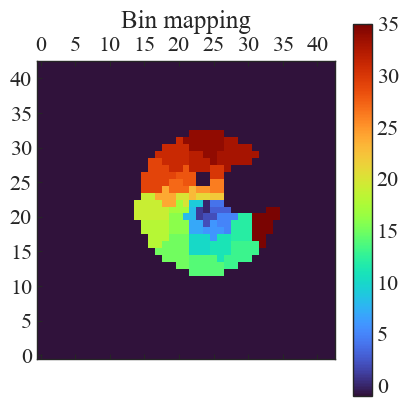

In [7]:
%matplotlib inline

bin_mapping = load_bin_mapping(target_snr_per_bin=snr_per_bin, plot=True);


### Fit PA and mean systematic velocity

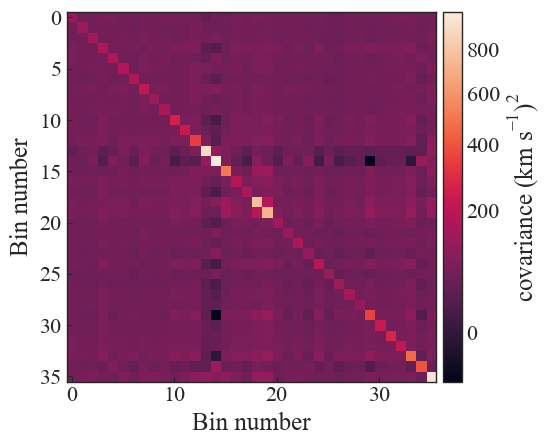

In [8]:
norm = simple_norm(covariance_velocity, 'sqrt')

fig = plt.figure()
ax = fig.add_subplot(111)


im = ax.imshow((covariance_velocity), norm=norm) #, cmap='gist')
#plt.colorbar(cbar, label=r'(km/s)${}^2$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad='2%')
cbar = fig.colorbar(im, cax=cax, label=r'covariance (km s$^{-1}$)$^{2}$')

ax.set_xlabel('Bin number')
ax.set_ylabel('Bin number')

fig.tight_layout()

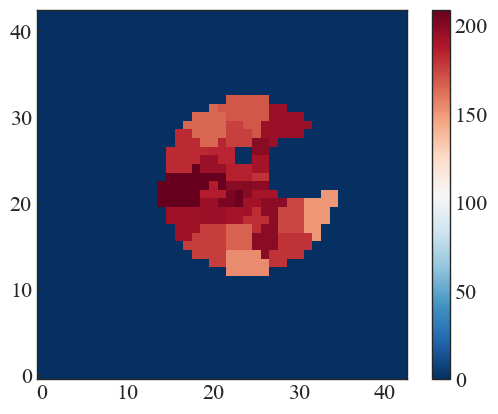

In [9]:
plt.imshow(get_kinematics_maps(binned_velocity, bin_mapping), origin='lower', cmap='RdBu_r')
plt.colorbar()

In [10]:
velocity_realizations = []

N = 3000

for i in tqdm_notebook(range(N)):
    binned_velocity_realization = np.random.multivariate_normal(mean=binned_velocity, 
                                                                cov=covariance_velocity) #np.loadtxt(file_id+'_mean.txt')

    V_2d_realization = get_kinematics_maps(binned_velocity_realization, bin_mapping)

    V_2d_realization[bin_mapping == -1] = np.nan

    V_2d_flat_realization = V_2d_realization.flatten()
    V_2d_flat_realization = V_2d_flat_realization[~np.isnan(V_2d_flat_realization)]
    
    velocity_realizations.append(V_2d_flat_realization)

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_5633/420121926.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(N)):


  0%|          | 0/3000 [00:00<?, ?it/s]

In [11]:
V_2d_cov = np.cov(velocity_realizations, rowvar=False)

In [12]:
V_2d_cov.shape

(277, 277)

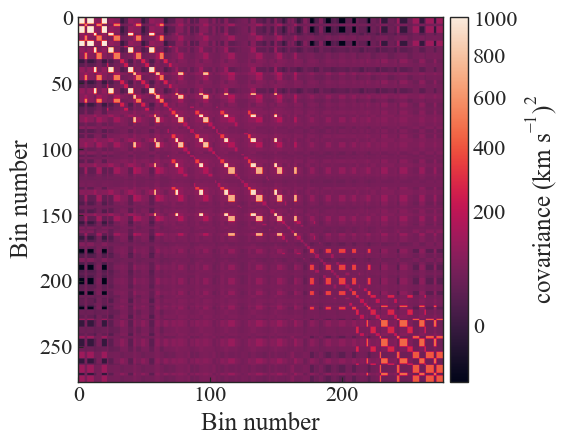

In [13]:
norm = simple_norm(V_2d_cov, 'sqrt')

fig = plt.figure()
ax = fig.add_subplot(111)


im = ax.imshow((V_2d_cov), norm=norm) #, cmap='gist')
#plt.colorbar(cbar, label=r'(km/s)${}^2$')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad='2%')
cbar = fig.colorbar(im, cax=cax, label=r'covariance (km s$^{-1}$)$^{2}$')

ax.set_xlabel('Bin number')
ax.set_ylabel('Bin number')

fig.tight_layout()

In [14]:
V_2d = get_kinematics_maps(binned_velocity, bin_mapping)
dV_2d = np.sqrt(get_kinematics_maps(np.diag(covariance_velocity), bin_mapping))
# loaded_vd = np.loadtxt(directory_measurements+'VD_'+vd_name+'.txt')

# VD_2d = get_kinematics_maps(loaded_vd[:, 1], bin_mapping)
# dVD_2d = get_kinematics_maps(loaded_vd[:, 3], bin_mapping)
# V_2d = get_kinematics_maps(loaded_vd[:, 0], bin_mapping)
# dV_2d = get_kinematics_maps(loaded_vd[:, 2], bin_mapping)

# VD_2d[bin_mapping == -1] = np.nan
# dVD_2d[bin_mapping == -1] = np.nan
V_2d[bin_mapping == -1] = np.nan
dV_2d[bin_mapping == -1] = np.nan

In [15]:
x_grid, y_grid = np.meshgrid(
    np.arange(-3.0597, 3.1597, 0.1457),  # x-axis points to negative RA
    np.arange(-3.0597, 3.1597, 0.1457),
)

x_center = 0  # 0.35490234894050443 # fitted from the KCWI cube
y_center = 2 * 0.1457  # 0.16776792706671506 # fitted from the KCWI cube

# x_grid -= x_center
# y_grid -= y_center

X_GRID, Y_GRID = np.meshgrid(
        -1 * np.arange(-3.0597, 3.1597, 0.1457),
        # x-axis points to negative RA
        np.arange(-3.0597, 3.1597, 0.1457),
    )

PIXEL_SIZE = 0.1457
X_CENTER = -(24 - 21.) * PIXEL_SIZE  # 23.5
Y_CENTER = (22 - 21.) * PIXEL_SIZE  # 21.5

X_GRID -= X_CENTER
Y_GRID -= Y_CENTER

x_grid = np.copy(X_GRID)
y_grid = np.copy(Y_GRID)

In [16]:
from pafit.fit_kinematic_pa import fit_kinematic_pa

V_2d_flat = V_2d.flatten()
dV_2d_flat = dV_2d.flatten()[~np.isnan(V_2d_flat)]
x_grid_flat = x_grid.flatten()[~np.isnan(V_2d_flat)]
y_grid_flat = y_grid.flatten()[~np.isnan(V_2d_flat)]
V_2d_flat = V_2d_flat[~np.isnan(V_2d_flat)]

plot = True
pa, sigma_pa, v_mean = fit_kinematic_pa(x_grid_flat, y_grid_flat, V_2d_flat,
                          quiet=False, plot=plot, dvel=dV_2d_flat, covariance_matrix=V_2d_cov)

#     v_rms = np.sqrt(VD_2d ** 2 + (V_2d - v_mean) ** 2)

#     sigma_rms = np.sqrt((VD_2d / v_rms) ** 2 * dVD_2d ** 2 + (
#             (V_2d - v_mean) / v_rms) ** 2 * dV_2d ** 2)
# else:
#     v_rms = VD_2d
#     sigma_rms = dVD_2d

  3%|███▋                                                                                                                                  | 10/361 [00:02<01:13,  4.80it/s]


KeyboardInterrupt: 

In [ ]:
pa, sigma_pa, v_mean

In [59]:
pa_light, sig_pa_light = 120.1, 0.4
delta_pa = pa_light - (180 - pa)

Text(0, 0.5, 'probability')

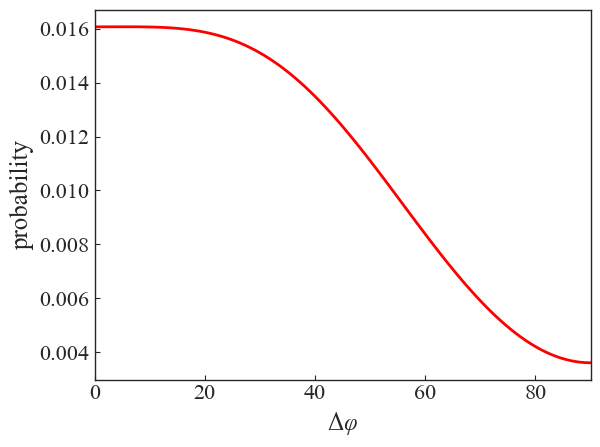

In [60]:
sig_pa = np.sqrt((sigma_pa / 3.)**2 + sig_pa_light**2)

# pa_points = np.linspace(-180, 180, 100)

# prob_delta_pas = 1 / np.sqrt(2*np.pi) / sig_pa * np.exp(-(pa_points - delta_pa)**2 / 2. / sig_pa**2)
# # prob_delta_pas = 1 / np.sqrt(2*np.pi) / sig_pa * np.exp(-((-pa_points - delta_pa)**2 / 2. / sig_pa**2))
# # prob_delta_pas = 1 / np.sqrt(2*np.pi) / sig_pa * np.exp(-((180 - pa_points) - delta_pa)**2 / 2. / sig_pa**2) 
# plt.plot(pa_points, prob_delta_pas)

# prob_delta_pas = 1 / np.sqrt(2*np.pi) / sig_pa * np.exp(-(pa_points+180 - delta_pa)**2 / 2. / sig_pa**2)
# # prob_delta_pas = 1 / np.sqrt(2*np.pi) / sig_pa * np.exp(-((-pa_points - delta_pa)**2 / 2. / sig_pa**2))
# # prob_delta_pas = 1 / np.sqrt(2*np.pi) / sig_pa * np.exp(-((180 - pa_points) - delta_pa)**2 / 2. / sig_pa**2) 
# plt.plot(pa_points, prob_delta_pas)

# prob_delta_pas = 1 / np.sqrt(2*np.pi) / sig_pa * np.exp(-(pa_points-180 - delta_pa)**2 / 2. / sig_pa**2)
# # prob_delta_pas = 1 / np.sqrt(2*np.pi) / sig_pa * np.exp(-((-pa_points - delta_pa)**2 / 2. / sig_pa**2))
# # prob_delta_pas = 1 / np.sqrt(2*np.pi) / sig_pa * np.exp(-((180 - pa_points) - delta_pa)**2 / 2. / sig_pa**2) 
# plt.plot(pa_points, prob_delta_pas)


pa_points = np.linspace(0, 90, 100)

prob_delta_pas = 1 / np.sqrt(2*np.pi) / sig_pa * np.exp(-(pa_points - delta_pa)**2 / 2. / sig_pa**2)
prob_delta_pas += 1 / np.sqrt(2*np.pi) / sig_pa * np.exp(-((-pa_points - delta_pa)**2 / 2. / sig_pa**2))
prob_delta_pas += 1 / np.sqrt(2*np.pi) / sig_pa * np.exp(-((180 - pa_points) - delta_pa)**2 / 2. / sig_pa**2) 
prob_delta_pas += 1 / np.sqrt(2*np.pi) / sig_pa * np.exp(-((pa_points-180) - delta_pa)**2 / 2. / sig_pa**2) 

plt.plot(pa_points, prob_delta_pas, lw='2', c='red')

# plt.axvline(0, c='k')
# plt.axvline(90, c='k')

# plt.ylim(0, 0.016)
plt.xlim(0, 90)
plt.xlabel(r'$\Delta \varphi$')
plt.ylabel(r'probability')

In [61]:
from scipy.integrate import quad


def p_of_delta_pa(x):
    """
    """
    return 1 / np.sqrt(2*np.pi) / sig_pa * np.exp(-(x - delta_pa)**2 / 2. / sig_pa**2)


obl_prob = quad(p_of_delta_pa, -45, 45)[0] + quad(p_of_delta_pa, 135, 180)[0] + quad(p_of_delta_pa, -180, -135)[0]
pro_prob = quad(p_of_delta_pa, 45, 135)[0] + quad(p_of_delta_pa, -135, -45)[0]

print(obl_prob, pro_prob)

0.6849519195166105 0.3150478085260006


## Get oblateness probability

In [62]:
delta_pa = np.array([
    2.6038461538461535,
    1.603846153846154,
    1.1,
    1.103846153846154,
    1.5038461538461538,
    1.3038461538461537,
    2.1038461538461535,
    2.6038461538461535,
    2.9038461538461537,
    3.407692307692307,
])

delta_pa_high = np.array([
    3.2076923076923074,
    1.9038461538461555,
    1.353846153846154,
    1.4038461538461484,
    1.8038461538461554,
    1.611538461538463,
    2.5038461538461547,
    3.0076923076923077,
    3.3038461538461537,
    3.853846153846153
])

delta_pa_uncertainty = (delta_pa_high - delta_pa)

In [63]:
bar_points = np.linspace(-90, 90, 20)
bar_points_half = ((bar_points[1:] + bar_points[:-1]) / 2.)[-10:]

bar_points_half[0] = 0

bar_points_half = 90 - bar_points_half

bar_points_half

array([90.        , 80.52631579, 71.05263158, 61.57894737, 52.10526316,
       42.63157895, 33.15789474, 23.68421053, 14.21052632,  4.73684211])

In [64]:
def func(params):
    """
    """
    amp1, sig1, amp2, sig2 = params
    
    density = amp1 * np.exp(-bar_points_half**2/2/sig1**2) \
            + amp2 * np.exp(-(90-bar_points_half)**2/2/sig2**2)
    
    return 0.5 * np.sum((density  - delta_pa)**2 / delta_pa_uncertainty**2)

def evaluate_func(x, params):
    """
    """
    amp1, sig1, amp2, sig2 = params
    
    density = amp1 * np.exp(-x**2/2./sig1**2) \
            + amp2 * np.exp(-(90-x)**2/2./sig2**2)
    
    return density

In [65]:
from scipy.optimize import minimize 

res = minimize(func, x0=[2.5, 15, 3.2, 35])

res

      fun: 1.8596148465765707
 hess_inv: array([[ 9.54599092e-02, -1.23058506e+00, -1.66519252e-02,
         6.46968892e-01],
       [-1.23058506e+00,  2.96737283e+01,  5.82403461e-01,
        -1.88277594e+01],
       [-1.66519252e-02,  5.82403461e-01,  2.41611468e-01,
        -1.38728474e+00],
       [ 6.46968892e-01, -1.88277594e+01, -1.38728474e+00,
         2.04052239e+01]])
      jac: array([-1.02818012e-06,  5.96046448e-08,  6.25848770e-07,  3.42726707e-07])
  message: 'Optimization terminated successfully.'
     nfev: 165
      nit: 30
     njev: 33
   status: 0
  success: True
        x: array([ 3.16941293, 38.04949909,  2.00350803, 11.54806677])

In [66]:
 2.00350875 / 3.16941299

0.6321387450361904

In [67]:
normalizing_factor = quad(evaluate_func, 0, 90, args=(res.x))[0] / 90

In [68]:
import copy


double_gauss_params = copy.deepcopy(res.x)

double_gauss_params[0] /= normalizing_factor
double_gauss_params[2] /= normalizing_factor

In [69]:
quad(evaluate_func, 0, 45, args=(double_gauss_params))[0] / 90, quad(evaluate_func, 45, 90, args=(double_gauss_params))[0] / 90

(0.650069792798516, 0.34993020720148404)

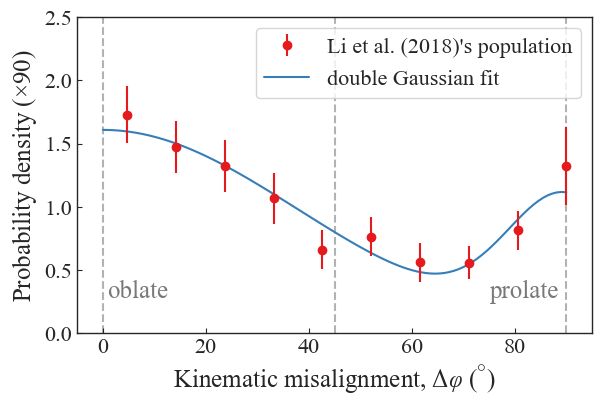

In [70]:
import copy


fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_colwidth*2))
ax = fig.add_subplot(111)

# ax.plot(pa_points, prob_delta_pas * 90, lw=2)

xs = np.linspace(0, 90, 100)
ax.plot(xs, evaluate_func(xs, double_gauss_params), c=pf.cb_blue, label='double Gaussian fit')

oblate_component = copy.deepcopy(res.x)
prolate_component = copy.deepcopy(res.x)
prolate_component[2] = 0
oblate_component[0] = 0

# ax.plot(90 - xs, evaluate_func(xs, prolate_component), ls=':', c=pf.cb_blue)
# ax.plot(90 - xs, evaluate_func(xs, oblate_component), ls=':', c=pf.cb_blue)

ax.set_ylim(0, 2.5)
ax.set_xlim(-5, 95)

ax.errorbar(bar_points_half, delta_pa/normalizing_factor, 
            yerr=delta_pa_uncertainty/normalizing_factor, 
            ls='None', marker='o', 
            color=pf.cb_red, label='Li et al. (2018)\'s population'
            )

# ax.set_yticklabels([])

ax.axvline(0, ls='--', c=pf.cb_grey, zorder=-20, alpha=0.4)
ax.axvline(45, ls='--', c=pf.cb_grey, zorder=-20, alpha=0.4)
ax.axvline(90, ls='--', c=pf.cb_grey, zorder=-20, alpha=0.4)

ax.set_xlabel(r'Kinematic misalignment, $\Delta \varphi$ (${}^{\circ}$)')
ax.set_ylabel(r'Probability density (${\times 90}$)')

# ax.set_yticklabels([]);

t = ax.text(.8, .5/160.5*90, 'oblate', color=pf.cb_grey, alpha=0.7) #, transform=ax.transAxes)
#t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='#dddddd'))
t = ax.text(75., .5/160.5*90, 'prolate', color=pf.cb_grey, alpha=0.7) #, transform=ax.transAxes)
#t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='#dddddd'))

# delta_pa_1131 = (120.74 - mean_pa)
# ax.text(120.74 - (180 - mean_pa) + 1, .5, r'RXJ1131$-$1231')

# ax.axvline(delta_pa_1131, ls='-', c=pf.cb_grey, zorder=-21)


# ax2 = ax.twinx() 
# sns.kdeplot(delta_pas, ax=ax, bw_adjust=102, color=pf.cb2_orange,
#             label=r'RXJ1131$-$1231'
#            ) #, density=True, bins=30, histtype='step', color=pf.cb2_orange, label='RXJ1131') #, ax=ax)



# sns.kdeplot(delta_pas, ax=ax2, bw_adjust=.2, color=pf.cb2_orange,
#             label=r'RXJ1131$-$1231'
#            ) #, density=True, bins=30, histtype='step', color=pf.cb2_orange, label='RXJ1131') #, ax=ax)

# iterate through rectangles, change the height of each
# for r in rects:
#     r.set_height(r.get_height()/r.get_width()/30)

# ax2.set_ylim(0, .13)
# ax2.set_yticks([])
# ax2.set_ylabel('')


handles, labels = ax.get_legend_handles_labels()
order = [1, 0]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='upper right')

# phis = 90 - xs
# ax.plot(phis, 
#         1e2*(#np.exp(-(phis - mean_pa)**2/2/pa_std**2) / np.sqrt(2*np.pi) / pa_std 
#               np.exp(-(phis + mean_pa)**2/2/pa_std**2) / np.sqrt(2*np.pi) / pa_std
#             )
#        )

# fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/oblateness_prior_population.pdf', 
#             bbox_inches='tight'
#            )

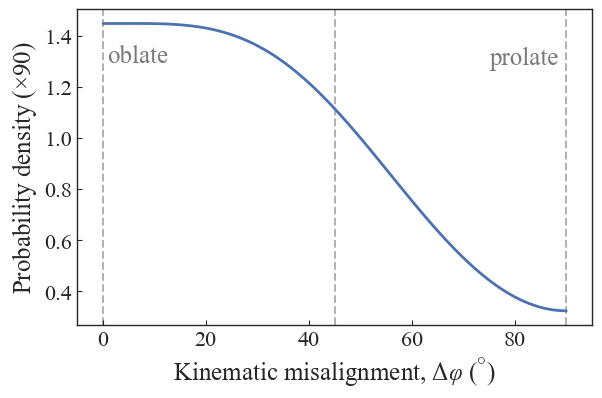

In [71]:
import copy


fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_colwidth*2))
ax = fig.add_subplot(111)

ax.plot(pa_points, prob_delta_pas * 90, lw=2)

xs = np.linspace(0, 90, 100)
# ax.plot(90 - xs, evaluate_func(xs, res.x), c=pf.cb_blue, label='double Gaussian fit')

oblate_component = copy.deepcopy(res.x)
prolate_component = copy.deepcopy(res.x)
prolate_component[2] = 0
oblate_component[0] = 0

# ax.plot(90 - xs, evaluate_func(xs, prolate_component), ls=':', c=pf.cb_blue)
# ax.plot(90 - xs, evaluate_func(xs, oblate_component), ls=':', c=pf.cb_blue)

# ax.set_ylim(0, 4.5)
ax.set_xlim(-5, 95)

# ax.errorbar(90-bar_points_half, delta_pa, yerr=delta_pa_uncertainty, ls='None', marker='o', 
#              color=pf.cb_red, label='Li et al. (2018)\'s population'
#             )

# ax.set_yticklabels([])

ax.axvline(0, ls='--', c=pf.cb_grey, zorder=-20, alpha=0.4)
ax.axvline(45, ls='--', c=pf.cb_grey, zorder=-20, alpha=0.4)
ax.axvline(90, ls='--', c=pf.cb_grey, zorder=-20, alpha=0.4)

ax.set_xlabel(r'Kinematic misalignment, $\Delta \varphi$ (${}^{\circ}$)')
ax.set_ylabel(r'Probability density (${\times 90}$)')
# ax.set_yticklabels([]);

t = ax.text(.8, 2.31/160.5*90, 'oblate', color=pf.cb_grey, alpha=0.7) #, transform=ax.transAxes)
#t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='#dddddd'))
t = ax.text(75., 2.3/160.5*90, 'prolate', color=pf.cb_grey, alpha=0.7) #, transform=ax.transAxes)
#t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='#dddddd'))

# delta_pa_1131 = (120.74 - mean_pa)
# ax.text(120.74 - (180 - mean_pa) + 1, .5, r'RXJ1131$-$1231')

# ax.axvline(delta_pa_1131, ls='-', c=pf.cb_grey, zorder=-21)


# ax2 = ax.twinx() 
# sns.kdeplot(delta_pas, ax=ax, bw_adjust=102, color=pf.cb2_orange,
#             label=r'RXJ1131$-$1231'
#            ) #, density=True, bins=30, histtype='step', color=pf.cb2_orange, label='RXJ1131') #, ax=ax)



# sns.kdeplot(delta_pas, ax=ax2, bw_adjust=.2, color=pf.cb2_orange,
#             label=r'RXJ1131$-$1231'
#            ) #, density=True, bins=30, histtype='step', color=pf.cb2_orange, label='RXJ1131') #, ax=ax)

# iterate through rectangles, change the height of each
# for r in rects:
#     r.set_height(r.get_height()/r.get_width()/30)

# ax2.set_ylim(0, .13)
# ax2.set_yticks([])
# ax2.set_ylabel('')


# handles, labels = ax.get_legend_handles_labels()
# order = [2, 0, 1]
# ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='upper center')
# phis = 90 - xs
# ax.plot(phis, 
#         1e2*(#np.exp(-(phis - mean_pa)**2/2/pa_std**2) / np.sqrt(2*np.pi) / pa_std 
#               np.exp(-(phis + mean_pa)**2/2/pa_std**2) / np.sqrt(2*np.pi) / pa_std
#             )
#        )

# fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/oblateness_prior.pdf', 
#             bbox_inches='tight'
#            )

# plot dispersion and mean velocity

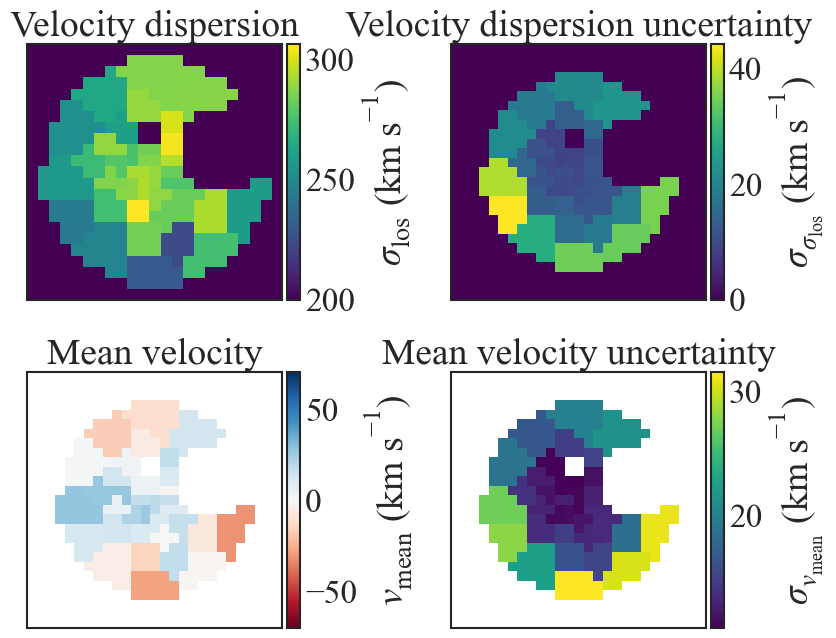

In [79]:
import matplotlib.colors as colors

pf.set_fontscale(3)

# cmap = palettable.cubehelix.perceptual_rainbow_16.mpl_colormap

vmax, vmin = 365, 55
mid = 265 #(vmax + vmin) / 2.
f = 25


def _forward(x):
    return np.arctan((x - mid)/f)


def _inverse(x):
    return np.tan(x)*f + mid


norm = colors.FuncNorm((_forward, _inverse), vmin=vmin, vmax=vmax)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

# extent = [15:38, 15:38]
VD_2d = get_kinematics_maps(binned_dispersion, bin_mapping)
dVD_2d = get_kinematics_maps(np.sqrt(np.diag(covariance)), bin_mapping)
    
im = axes[0][0].imshow(VD_2d[11:34, 13:36], cmap='viridis', origin='lower', vmin=200) #, norm=norm)
divider = make_axes_locatable(axes[0][0])
cax = divider.append_axes('right', size='5%', pad='2%')
cbar = plt.colorbar(im, cax=cax, label=r'$\sigma_{\rm los}$ (km s$^{-1}$)', ticks=[350, 300, 250, 200, 0])
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])
axes[0][0].set_title('Velocity dispersion')

im = axes[0][1].imshow(dVD_2d[9:36, 11:38], cmap='viridis', origin='lower') #, extent=extent)
divider = make_axes_locatable(axes[0][1])
cax = divider.append_axes('right', size='5%', pad='2%')
cbar = plt.colorbar(im, cax=cax, label=r'$\sigma_{\sigma_{\rm los}}$ (km s$^{-1}$)')
axes[0][1].set_xticks([])
axes[0][1].set_yticks([])
axes[0][1].set_title('Velocity dispersion uncertainty')

im = axes[1][0].imshow((V_2d-v_mean)[9:36, 11:38], cmap='RdBu', origin='lower', vmax=70, vmin=-70) #, extent=extent)
divider = make_axes_locatable(axes[1][0])
cax = divider.append_axes('right', size='5%', pad='2%')
cbar = plt.colorbar(im, cax=cax, label=r'$v_{\rm mean}$ (km s$^{-1}$)')
axes[1][0].set_xticks([])
axes[1][0].set_yticks([])
axes[1][0].set_title('Mean velocity')

im = axes[1][1].imshow(dV_2d[9:36, 11:38], cmap='viridis', origin='lower') #, extent=extent)
divider = make_axes_locatable(axes[1][1])
cax = divider.append_axes('right', size='5%', pad='2%')
cbar = plt.colorbar(im, cax=cax, label=r'$\sigma_{v_{\rm mean}}$ (km s$^{-1}$)')
axes[1][1].set_xticks([])
axes[1][1].set_yticks([])
axes[1][1].set_title('Mean velocity uncertainty')


#fig.tight_layout()
plt.subplots_adjust(wspace=.55, hspace=-.1)

# fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/velocity_dispersion_maps.pdf', 
#             bbox_inches='tight'
#            )

# Make radial plot

In [17]:
import scipy.interpolate as interp
from tqdm import tqdm_notebook


r = np.linspace(-2, 2, 2000)

def select_pixel(ra, dec):
    """
    """
    x_pixel_size = x_grid[0, 1] - x_grid[0, 0]
    y_pixel_size = y_grid[1, 0] - y_grid[0, 0]

    a, b = None, None
    for i in range(x_grid.shape[1]):
        x_down = x_grid[0, i] - x_pixel_size / 2
        x_up = x_grid[0, i] + x_pixel_size / 2
        
        if x_down > x_up:
            x_down, x_up = x_up, x_down
        
        if (x_down <= ra <= x_up):
            a = np.copy(i)
            break
        
    for i in range(x_grid.shape[1]):
        y_down = y_grid[i, 0] - y_pixel_size / 2
        y_up = y_grid[i, 0] + y_pixel_size / 2
        
        if y_down > y_up:
            y_down, y_up = y_up, y_down
            
        if (y_down <= dec <= y_up):
            b = np.copy(i)
            break
            
    return a, b
                
# for i in tqdm_notebook(range(100)):
if True:
#     vel_dis_realization = np.random.multivariate_normal(mean=binned_dispersion, cov=covariance)
    vel_dis_map = get_kinematics_maps(binned_dispersion, bin_mapping)
    vel_dis_uncertainty_map = get_kinematics_maps(np.sqrt(np.diag(covariance)), bin_mapping)

    f = interp.interp2d(x_grid.flatten(), y_grid.flatten(), vel_dis_map.flatten())
    
    vel_dis_map_copy = np.copy(vel_dis_map)
    
    def interpolate(x, y, arr):
        """
        """
#         return interp.dfitpack.bispeu(f.tck[0], f.tck[1], f.tck[2], f.tck[3], f.tck[4], x, y)[0]
#         return [f(a, b)[0] for (a, b) in zip(x, y)]
        
        values = []
        for _x, _y in zip(x, y):
            #print(_x, _y)
            a, b = select_pixel(_x, _y)
            #print(a, b)
            if a is None or b is None:
                values.append(np.nan)
            else:
                values.append(arr[b, a])
                vel_dis_map_copy[b, a] = 0
                
        return np.array(values)

    phi = (121.7 - 90.) * np.pi / 180.

    major_x = -r * np.cos(phi) 
    major_y = r * np.sin(phi)

    minor_x = r * np.sin(phi) 
    minor_y = r * np.cos(phi)
    
#     vel_dis_profiles_major.append(interpolate(major_x, major_y, vel_dis_map))
#     vel_dis_profiles_major.append(interpolate(-major_x, -major_y, vel_dis_map))

#     vel_dis_profiles_minor.append(interpolate(minor_x, minor_y, vel_dis_uncertainty_map))
#     vel_dis_profiles_minor.append(interpolate(-minor_x, -minor_y, vel_dis_uncertainty_map))
    
    vel_dis_profile_major = (interpolate(major_x, major_y, vel_dis_map)) # + interpolate(-major_x, -major_y, vel_dis_map))/2.
    vel_dis_uncertainty_major = np.sqrt(interpolate(major_x, major_y, vel_dis_uncertainty_map)**2) # + interpolate(-major_x, -major_y, vel_dis_uncertainty_map)**2)
    
    vel_dis_profile_minor = (interpolate(minor_x, minor_y, vel_dis_map)) # + interpolate(-minor_x, -minor_y, vel_dis_map))/2.
    vel_dis_uncertainty_minor = np.sqrt(interpolate(minor_x, minor_y, vel_dis_uncertainty_map)**2) # + interpolate(-minor_x, -minor_y, vel_dis_uncertainty_map)**2)
    
    
    vel_profile_major = (interpolate(major_x, major_y, V_2d-v_mean)) # + interpolate(-major_x, -major_y, V_2d-v_mean))/2.
    vel_uncertainty_major = np.sqrt(interpolate(major_x, major_y, dV_2d)**2) # + interpolate(-major_x, -major_y, dV_2d)**2)
    
    vel_profile_minor = (interpolate(minor_x, minor_y, V_2d-v_mean)) # + interpolate(-minor_x, -minor_y, V_2d-v_mean))/2.
    vel_uncertainty_minor = np.sqrt(interpolate(minor_x, minor_y, dV_2d)**2) # + interpolate(-minor_x, -minor_y, dV_2d)**2)
    
    fig = plt.figure()
    
    ax = fig.add_subplot(111)

#     ax.plot(major_x, major_y)
#     ax.plot(minor_x, minor_y)
#     ax.set_aspect('equal')
#     ax.set_xlim(2, -2)
#     ax.set_ylim(-2, 2)

    ax.imshow(vel_dis_map_copy, origin='lower', cmap='viridis')
    ax.set_title('Illustration of major and minor axis')
#break

/Users/ajshajib/miniforge3/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=1,1 nx,ny=35,35 m=1849 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


NameError: name 'v_mean' is not defined

### modelled profiles

In [18]:
from plot_util import *

In [19]:
prolate_params = get_most_likely_value('jampy', 'ifu', 'constant', 'axisymmetric', 'powerlaw', snr=23, shape='prolate')
oblate_params = get_most_likely_value('jampy', 'ifu', 'constant', 'axisymmetric', 'powerlaw', snr=23, shape='oblate')

In [20]:
from dynamical_model import DynamicalModel

dyn_model = DynamicalModel('powerlaw')

In [21]:
def get_profiles(xs, ys, shape, moment='zz', params=None):
    """
    """
    if params is None:
        if shape == 'prolate':
            params = prolate_params
        else:
            params = oblate_params
        
    theta_e, gamma, q, D_dt, D_d, inclination, lamda, ani_param = params
    lens_params = [theta_e, gamma, q]
    cosmo_params = [lamda, D_dt, D_d]
        
    return dyn_model.compute_jampy_v_rms_model(lens_params, 
                                               cosmo_params,
                                               ani_param=ani_param,
                                               inclination=inclination,
                                               anisotropy_model='constant',
                                               moment=moment,
                                               x_points=xs, y_points=ys,
                                               shape=shape
                                              )

In [ ]:
vel_dis_model_major_prolate = get_profiles(r, r*0, 'prolate', 'zz')
vel_dis_model_minor_prolate = get_profiles(r*0, r, 'prolate', 'zz')
vel_dis_model_major_oblate = get_profiles(r, r*0, 'oblate', 'zz')
vel_dis_model_minor_oblate = get_profiles(r*0, r, 'oblate', 'zz')


vel_model_major_prolate = get_profiles(r, r*0, 'prolate', 'z')
vel_model_minor_prolate = get_profiles(r*0, r, 'prolate', 'z')
vel_model_major_oblate = get_profiles(r, r*0, 'oblate', 'z')
vel_model_minor_oblate = get_profiles(r*0, r, 'oblate', 'z')

# Plot profiles

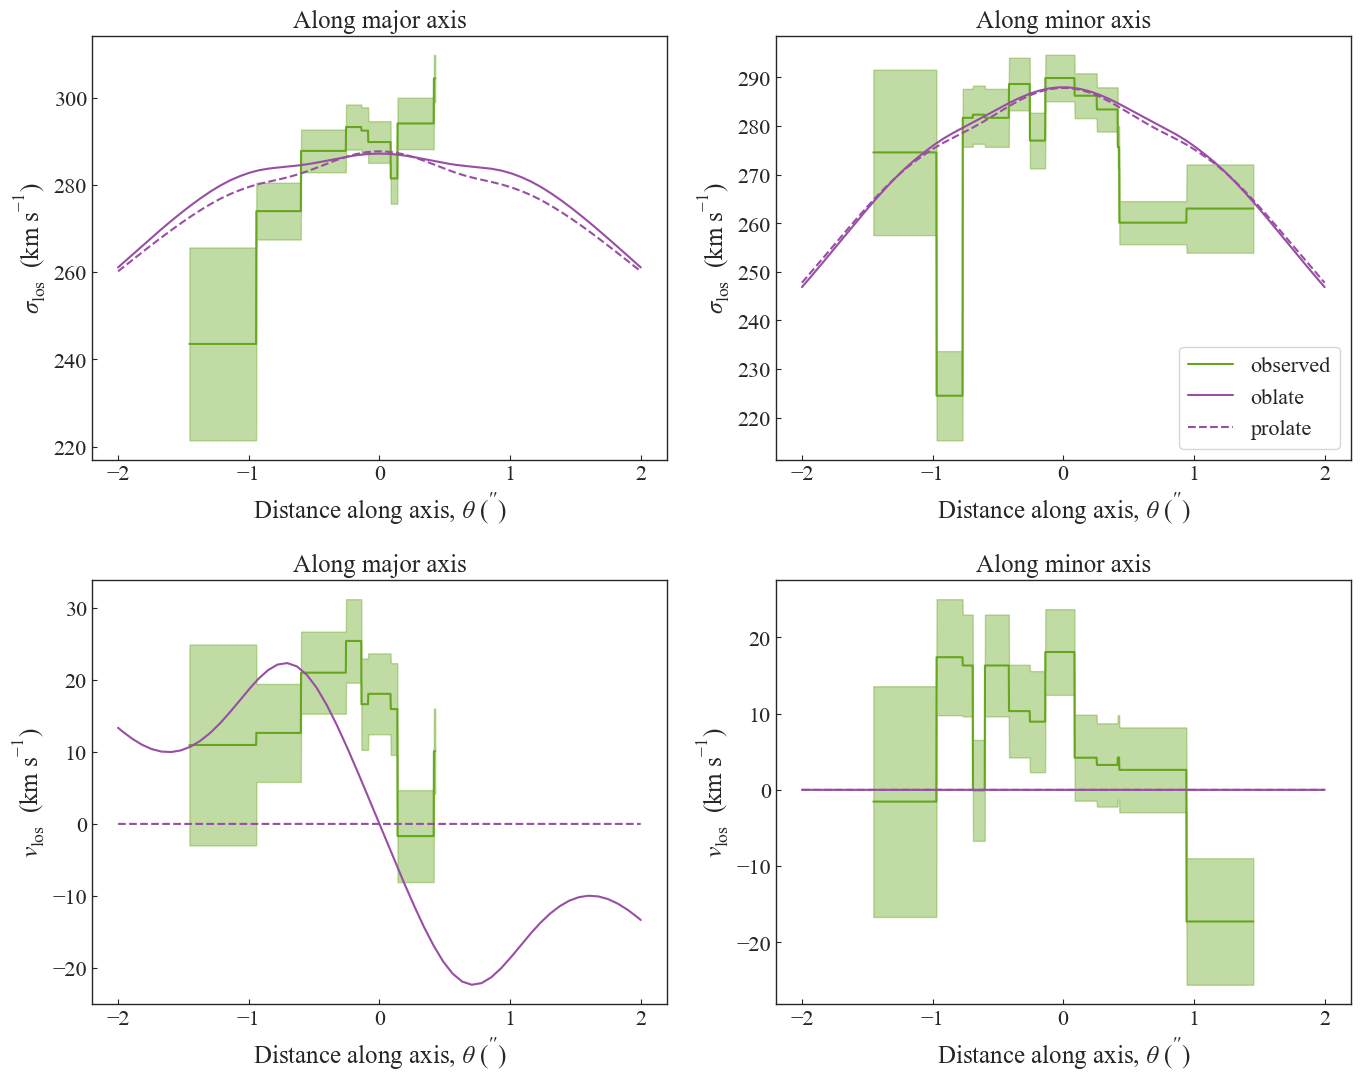

In [108]:
pf.set_fontscale(2.)
fig = plt.figure(figsize=pf.get_fig_size(width=2*pf.mnras_textwidth, height_ratio=.8))

ax = fig.add_subplot(221)


vel_dis_profile_major[vel_dis_profile_major == 0] = np.nan
vel_dis_profile_minor[vel_dis_profile_minor == 0] = np.nan

colors = [ pf.cb_purple, '#66a61e', '#7570b3']


## sigma(r)
ax.plot(r, vel_dis_profile_major, label='along major axis', c=colors[1])
ax.fill_between(r, vel_dis_profile_major+vel_dis_uncertainty_major/2., 
                vel_dis_profile_major-vel_dis_uncertainty_major/2., alpha=0.4, color=colors[1])

ax.plot(r, vel_dis_model_major_oblate, '-', c=colors[0])
ax.plot(r, vel_dis_model_major_prolate, '--', c=colors[0])

# ax.set_xlim(0., 2.)
#ax.set_ylim(100, 400)
ax.set_title('Along major axis')
ax.set_xlabel(r'Distance along axis, $\theta$ ($^{\prime\prime}$)')
ax.set_ylabel(r'$\sigma_{\rm los}$  (km s$^{-1}$)')


ax = fig.add_subplot(222)

ax.plot(r, vel_dis_profile_minor, label='observed', c=colors[1])
ax.fill_between(r, vel_dis_profile_minor+vel_dis_uncertainty_minor/2., 
                vel_dis_profile_minor-vel_dis_uncertainty_minor/2., alpha=0.4, color=colors[1])
# ax.fill_between(r, minor_low, minor_hi, alpha=0.4)

ax.plot(r, vel_dis_model_minor_oblate, '-', c=colors[0], label='oblate')
ax.plot(r, vel_dis_model_minor_prolate, '--', c=colors[0], label='prolate')

ax.legend(loc='lower right')
# ax.set_xlim(0., 2.)
#ax.set_ylim(100, 400)
ax.set_title('Along minor axis')
ax.set_xlabel(r'Distance along axis, $\theta$ ($^{\prime\prime}$)')
ax.set_ylabel(r'$\sigma_{\rm los}$  (km s$^{-1}$)')

## v(r)
ax = fig.add_subplot(223)
ax.plot(r, vel_profile_major, label='along major axis', c=colors[1])
ax.fill_between(r, vel_profile_major+vel_uncertainty_major/2., 
                vel_profile_major-vel_uncertainty_major/2., alpha=0.4, color=colors[1])

ax.plot(r, -vel_model_major_oblate, '-', c=colors[0])
ax.plot(r, -vel_model_major_prolate, '--', c=colors[0])

# ax.set_xlim(0., 2.)
#ax.set_ylim(100, 400)
ax.set_title('Along major axis')
ax.set_xlabel(r'Distance along axis, $\theta$ ($^{\prime\prime}$)')
ax.set_ylabel(r'$v_{\rm los}$  (km s$^{-1}$)')


ax = fig.add_subplot(224)
ax.plot(r, vel_profile_minor, label='observed', c=colors[1])
ax.fill_between(r, vel_profile_minor+vel_uncertainty_minor/2., 
                vel_profile_minor-vel_uncertainty_minor/2., alpha=0.4, color=colors[1])
# ax.fill_between(r, minor_low, minor_hi, alpha=0.4)

ax.plot(r, vel_model_minor_oblate, '-', c=colors[0], label='model')
ax.plot(r, vel_model_minor_prolate, '--', c=colors[0], label='model')

# ax.legend(loc='lower left')
# ax.set_xlim(0., 2.)
#ax.set_ylim(100, 400)
ax.set_title('Along minor axis')
ax.set_xlabel(r'Distance along axis, $\theta$ ($^{\prime\prime}$)')
ax.set_ylabel(r'$v_{\rm los}$  (km s$^{-1}$)')

fig.tight_layout()

# fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/velocity_moment_profile.pdf', 
#             bbox_inches='tight'
#            )

## plot radial profiles

In [23]:
import h5py as h5

with h5.File('./data_products/radially_binned_dispersion.h5', 'r') as f:
    radially_binned_dispersion = np.array(f['binned_dispersion'])
    radial_bins = np.array(f['radial_bins'])
    covariance_radial_bins = np.array(f['covariance'])

In [24]:
N = 10
radial_profiles_oblate = []
radial_profiles_prolate = []

oblate_chain = get_chain('jampy', 'ifu', 'constant', 'axisymmetric', 'powerlaw', snr=23, shape='oblate', burnin=-300)


random_indexes = np.random.randint(low=0, high=oblate_chain.shape[0], size=N, )

for i in range(N):
    params = oblate_chain[random_indexes[i], :]
    radial_profiles_oblate.append(get_profiles(r*np.cos(np.pi/4), r*np.sin(np.pi/4), 'oblate', 'zz', params=params))

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


In [25]:
params = get_most_likely_value('jampy', 'ifu', 'constant', 'axisymmetric', 'powerlaw', snr=23, shape='oblate', burnin=-300)

In [26]:
params

array([1.63257834e+00, 1.96882217e+00, 7.59234279e-01, 2.84089065e+03,
       8.78358468e+02, 1.22876807e+02, 6.63475183e-01, 9.14837851e-01])

In [27]:
params[-2] = 1
params[-1] = 0.8

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


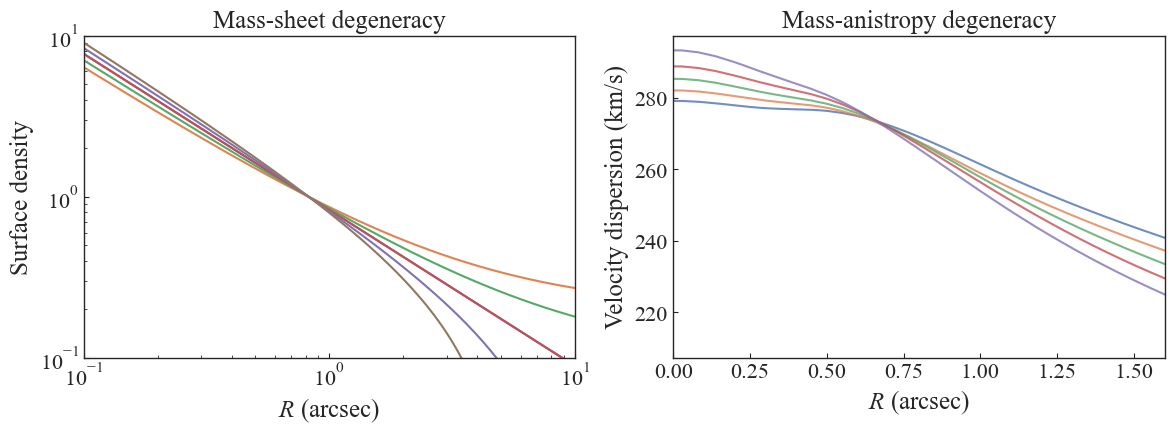

In [62]:
fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_textwidth*2, height_ratio=0.3))

ax = fig.add_subplot(122)

# ax.errorbar(x=(radial_bins[:-1]+np.diff(radial_bins)/2.), 
#             y=radially_binned_dispersion, 
#             xerr=np.diff(radial_bins)/2,
#             yerr=np.sqrt(np.diag(covariance_radial_bins)),
#             color=pf.cb_red,
#             ls='None', marker='o'
#            )
    
for a, l in zip(np.linspace(1.1, 0.9, 5), np.linspace(1.02, .98, 5)):
# for i in np.linspace(0.87, 1.12, 5):
#     params[-2] = 1
    params[-1] = a
#     pr = get_profiles(2*r*np.cos(np.pi/4), 2*r*np.sin(np.pi/4), 'oblate', 'zz', params=params)
    
#     l = 280 / np.mean(pr)
    params[-2] = l
    pr = get_profiles(2*r*np.cos(np.pi/4), 2*r*np.sin(np.pi/4), 'oblate', 'zz', params=params)
    ax.plot(r, pr/1.2, alpha=0.8) #, label=r'$\lambda=${:.2f}, $\beta=${:.2f}'.format(l, 1 - a**2))
    
# for i in range(len(radial_profiles_oblate)):
#     ax.plot(r, radial_profiles_oblate[i], c=pf.cb_purple, alpha=0.4)

ax.set_xlabel(r'$R$ (arcsec)')
ax.set_ylabel(r'Velocity dispersion (km/s)')
ax.set_xlim(0, 1.6)

ax.set_title('Mass-anistropy degeneracy')
# ax.legend()

ax = fig.add_subplot(121)
ax.loglog(r_array, mass_r)

for l in np.linspace(0.8, 1.2, 5):
    ax.loglog(r_array, l*mass_r + 1 - l, label=l)
    
# plt.ylim(1e-10, 1e3)
ax.set_ylim(1e-1, 1e1)
ax.set_xlim(1e-1, 1e1)

ax.set_xlabel(r'$R$ (arcsec)')
ax.set_ylabel(r'Surface density')

ax.set_title('Mass-sheet degeneracy')

# ax.legend()

# plt.show()
fig.savefig('/Users/ajshajib/Downloads/mad.pdf', bbox_inches='tight')

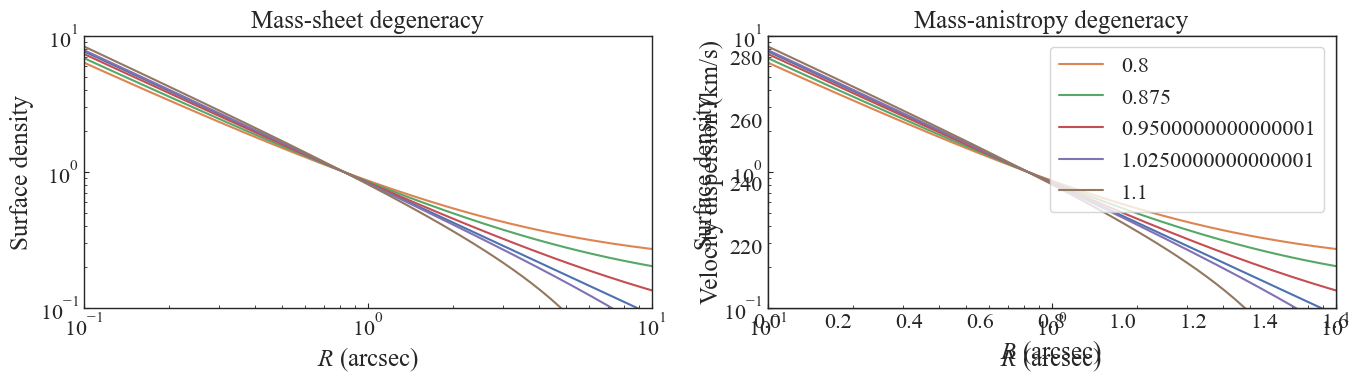

In [51]:
fig.tight_layout()

fig

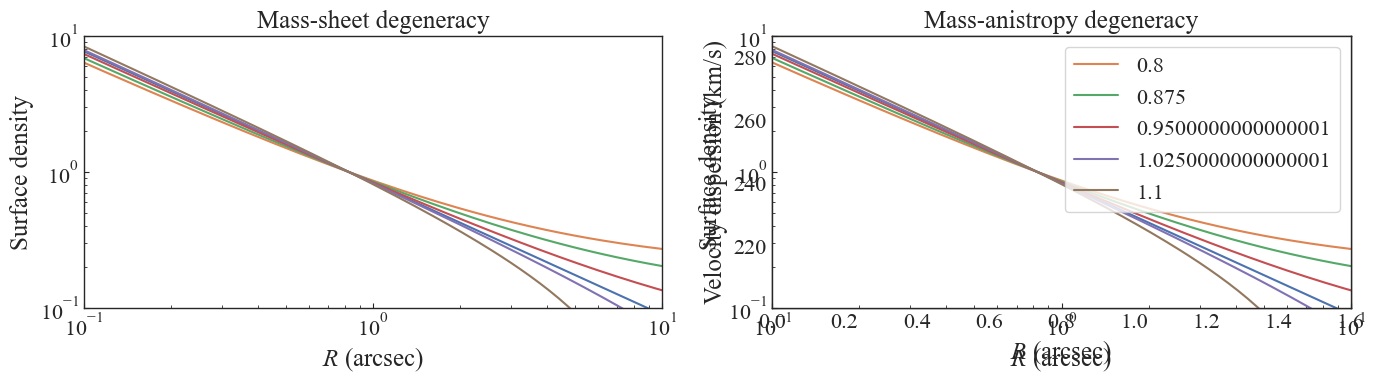

In [49]:
ax = fig.add_subplot(122)
ax.loglog(r_array, mass_r)

for l in np.linspace(0.8, 1.1, 5):
    ax.loglog(r_array, l*mass_r + 1 - l, label=l)
    
# plt.ylim(1e-10, 1e3)
ax.set_ylim(1e-1, 1e1)
ax.set_xlim(1e-1, 1e1)

ax.set_xlabel(r'$R$ (arcsec)')
ax.set_ylabel(r'Surface density')

ax.legend()

fig

In [34]:
from lenstronomy.LensModel.lens_model import LensModel

theta_e, gamma, q = params[:3]

n = 300
r_array = np.logspace(np.log10(10 ** -2.5),
                      np.log10(10 ** 2.5),
                      n)

lens_model = LensModel(['PEMD'])

# take spherical mass profile for mge_1d
kwargs_lens = [
    {'theta_E': theta_e, 'gamma': gamma, 'e1': 0., 'e2': 0.,
     'center_x': 0., 'center_y': 0.}]

mass_r = lens_model.kappa(r_array, r_array * 0, kwargs_lens)

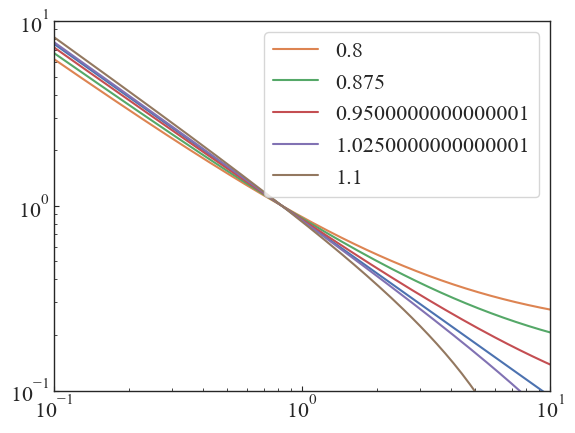

## intrinsic q prior

In [188]:
xs = np.linspace(0, 1, 100)

kinematic_likelihood = KinematicLikelihood('powerlaw', shape='oblate')
intrinsic_q_oblate = kinematic_likelihood.get_intrinsic_q_prior(xs)

kinematic_likelihood = KinematicLikelihood('powerlaw', shape='prolate')
intrinsic_q_prolate = kinematic_likelihood.get_intrinsic_q_prior(xs)

/Users/ajshajib/Research/RXJ1131_KCWI/RXJ1131_KCWI_kinematics/kinematics_likelihood.py:237: RuntimeWarning: divide by zero encountered in log
  return np.log(self._intrinsic_q_prior_interp(intrinsic_q))


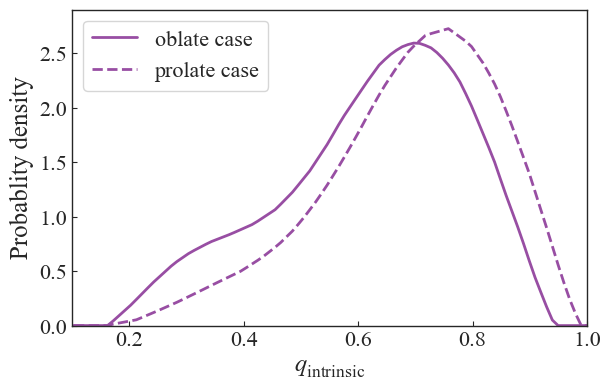

In [189]:
fig = plt.figure(figsize=pf.get_fig_size(width=pf.mnras_colwidth*2))

ax = fig.add_subplot(111)

ax.plot(xs, np.exp(intrinsic_q_oblate), label='oblate case', color=pf.cb_purple, lw=2, ls='-')
ax.plot(xs, np.exp(intrinsic_q_prolate), label='prolate case', color=pf.cb_purple, zorder=-2, lw=2, ls='--')

ax.set_xlabel(r'$q_{\rm intrinsic}$')
ax.set_ylabel(r'Probablity density')
ax.set_xlim(0.1, 1)
ax.set_ylim(0, 2.9)
# ax.set_yticklabels([])
ax.legend()

fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/q_intrinsic_prior.pdf', 
            bbox_inches='tight'
           )